<a href="https://colab.research.google.com/github/JohEder/bachelor_thesis_audio_ml/blob/master/base_line_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 35.3MB/s 


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset 
import torchaudio
import pandas as pd
import os

In [3]:
#just copied the official import script for the dataset, custom preprocessing happens afterwards
""" Import script for IDMT-Traffic dataset
Ref:
    J. Abeßer, S. Gourishetti, A. Kátai, T. Clauß, P. Sharma, J. Liebetrau: IDMT-Traffic: An Open Benchmark
    Dataset for Acoustic Traffic Monitoring Research, EUSIPCO, 2021
"""

import os
import glob
import pandas as pd

__author__ = 'Jakob Abeßer (jakob.abesser@idmt.fraunhofer.de)'


def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """
    # load file list
    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    # load metadata from file names
    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

In [4]:

"""
Baseline Model for my Bachelor Thesis

"""

__author__ = 'Johannes Eder (Jo.Eder@campus.lmu.de)'

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
CLASSES = ['None','C','T', 'M', 'B'] #Background Noise, Car, Truck, Motorcycle, Bus
NORMAL_CLASSES = ['None']
ANOMALOUS_CLASSES = ['C','T', 'M', 'B']

In [9]:
class IdmtTrafficDataSet(Dataset):

    def __init__(self, annotations_file, audio_dir, audio_transformation, transformation, target_sample_rate, normal_classes):
        self.annotations =  annotations_file if isinstance(annotations_file, pd.DataFrame) else pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.audio_transformation = audio_transformation
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        #self.classes = ['None','C','T', 'M', 'B']
        self.normal_classes = normal_classes


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample(signal, sr) #adjust sample rates
        # signal -> (num_channels, samples) i.e. (2, 16000)
        signal  = self._mix_down(signal) #stereo to mono
        signal = self.audio_transformation(signal) #(1, 16000) -> torch.Size([1, 64, 63])
        signal = self.transformation(signal)
        #label = self.normal_classes.index(label)
        label = 0 if label in self.normal_classes else 1 #1 for normal 0 for anomalous
        return signal, label

    def _resample(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal
    
    def _mix_down(self, signal):
        if signal.shape[0] > 1: #(2, 16000)
            #mean operation: aggregating multiple channels
            signal = torch.mean(signal, 0, True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path + '.wav'

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]

In [10]:
SAMPLE_RATE = 22500
N_FFT=2048 #is also window size
HOP_LENGTH=1024
N_MELS=128
melspectogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT, # Frame Size
        hop_length=HOP_LENGTH, #here half the frame size
        n_mels=N_MELS
    )

transforms = transforms.Compose([
    transforms.ToPILImage(mode='L'),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [11]:
    AUDIO_DIR = "/content/drive/My Drive/datasets/IDMT_Traffic/audio"
    train_annotations = "/content/drive/My Drive/datasets/IDMT_Traffic/annotation/eusipco_2021_train.csv"
    test_annotatons = "/content/drive/My Drive/datasets/IDMT_Traffic/annotation/eusipco_2021_test.csv"
    all_annotations_txt = "/content/drive/My Drive/datasets/IDMT_Traffic/annotation/idmt_traffic_all.txt"

In [12]:
def get_train_and_val_idmt(audio_dir, train_annotations, test_annotations):
    #this method is for the classifciation task

    train_data = IdmtTrafficDataSet(train_annotations, audio_dir,melspectogram, transforms, SAMPLE_RATE)
    test_data = IdmtTrafficDataSet(test_annotatons, audio_dir,melspectogram, transforms, SAMPLE_RATE)
    return train_data, test_data

def get_normal_and_anomalous_data(normal_classes, anomalous_classes, audio_dir, annotations, batch_size):
    #this method is for the AD Task

    all_data = import_idmt_traffic_dataset(annotations)

    normal_data = all_data[all_data.vehicle.isin(normal_classes)]
    anomalous_data = all_data[all_data.vehicle.isin(anomalous_classes)]

    train_data = normal_data.iloc[:6000, :] #test data needs to have some amount of normal data as well
    train_data = adjust_frame_to_batch_size(train_data, batch_size)

    normal_test_data = normal_data.iloc[6001:, :]
    number_of_normal_test_sampels = len(normal_test_data)
    print(f"testing with {number_of_normal_test_sampels} normal samples")

    #sample same number of anomalous data to test
    anomalous_data = anomalous_data.sample(number_of_normal_test_sampels)

    frames = [anomalous_data, normal_test_data]
    concatenated_test_data = pd.concat(frames)
    concatenated_test_data.reset_index(drop=True, inplace=True)
    concatenated_test_data = adjust_frame_to_batch_size(concatenated_test_data, batch_size)

    normal_train_data = IdmtTrafficDataSet(train_data, audio_dir, melspectogram, transforms, SAMPLE_RATE, normal_classes)
    test_data = IdmtTrafficDataSet(concatenated_test_data, audio_dir, melspectogram, transforms, SAMPLE_RATE, normal_classes)

    return normal_train_data, test_data

def adjust_frame_to_batch_size(data, batch_size):
  if len(data) % batch_size == 0:
    return data
  else:
    remainder = len(data) % batch_size
    return data.iloc[remainder + 1:,:]

In [13]:
class AutoEncoder(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.encoder = nn.Sequential(
        #FC(Input, 64, ReLU)
        nn.Linear(in_features=input_dim, out_features=64),
        nn.ReLU(),
        #FC(64, 32, ReLU),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        #FC(32, 16, ReLU)
        nn.Linear(in_features=32, out_features=16),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        #FC(16, 32,ReLU)
        nn.Linear(in_features=16, out_features=32),
        nn.ReLU(),
        #FC(32, 64, ReLU), 
        nn.Linear(in_features=32, out_features=64),
        nn.ReLU(),
        #FC(64, Output, none)
        nn.Linear(in_features=64, out_features=input_dim),
        nn.ReLU()
    )

  def forward(self, input_data):
    z = self.encoder(input_data)
    output = self.decoder(z)
    return output

In [14]:
LEARNING_RATE = 0.00001
EPOCHS = 5
BATCH_SIZE = 16

train_data, test_data = get_normal_and_anomalous_data(NORMAL_CLASSES, ANOMALOUS_CLASSES, audio_dir=AUDIO_DIR, annotations=all_annotations_txt, batch_size=BATCH_SIZE)
first_sample, first_label = train_data[0]
input_dim = first_sample.shape[1] *first_sample.shape[2]
print(f"Train Data Shape: {first_sample.shape}")
print(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = AutoEncoder(input_dim=input_dim)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
loss_func = nn.MSELoss()

testing with 2143 normal samples
Train Data Shape: torch.Size([1, 128, 44])
5632


In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
def train(model, input_dim, device, train_loader, optimizer, epoch, loss_func):
  print(f"Starting Epoch {epoch}")
  model.to(device)
  model.train() #set mode
  for batch_index, (data_batch, _) in enumerate(train_loader):
    data_batch = data_batch.view(-1, input_dim).to(device)

    optimizer.zero_grad()
    output = model(data_batch)

    # Calculate loss
    loss = loss_func(output, data_batch)
    loss.backward()                 
    optimizer.step()
    
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_index * len(data_batch), len(train_loader.dataset),100. * batch_index / len(train_loader), loss.item()))

In [17]:
for epoch in range(1, EPOCHS + 1):
  train(autoencoder, input_dim, device, train_loader, optimizer, epoch, loss_func)
  print("epoch : {}/{}".format(epoch, EPOCHS))

Starting Epoch 1
Train Epoch: 1 [0/6000 (0%)]	Loss: 0.012892
Train Epoch: 1 [16/6000 (0%)]	Loss: 0.015142
Train Epoch: 1 [32/6000 (1%)]	Loss: 0.008105
Train Epoch: 1 [48/6000 (1%)]	Loss: 0.011035
Train Epoch: 1 [64/6000 (1%)]	Loss: 0.012403
Train Epoch: 1 [80/6000 (1%)]	Loss: 0.019873
Train Epoch: 1 [96/6000 (2%)]	Loss: 0.013640
Train Epoch: 1 [112/6000 (2%)]	Loss: 0.006451
Train Epoch: 1 [128/6000 (2%)]	Loss: 0.008768
Train Epoch: 1 [144/6000 (2%)]	Loss: 0.012324
Train Epoch: 1 [160/6000 (3%)]	Loss: 0.011851
Train Epoch: 1 [176/6000 (3%)]	Loss: 0.005683
Train Epoch: 1 [192/6000 (3%)]	Loss: 0.019408
Train Epoch: 1 [208/6000 (3%)]	Loss: 0.007886
Train Epoch: 1 [224/6000 (4%)]	Loss: 0.009138
Train Epoch: 1 [240/6000 (4%)]	Loss: 0.016811
Train Epoch: 1 [256/6000 (4%)]	Loss: 0.014048
Train Epoch: 1 [272/6000 (5%)]	Loss: 0.007447
Train Epoch: 1 [288/6000 (5%)]	Loss: 0.013937
Train Epoch: 1 [304/6000 (5%)]	Loss: 0.008164
Train Epoch: 1 [320/6000 (5%)]	Loss: 0.011604
Train Epoch: 1 [336/6000 

In [18]:
def evaluate(model, val_loader, device):
  anom_scores = []
  targets = []
  model.to(device)
  model.eval()
  with torch.no_grad():
    for _, data in enumerate(val_loader, 0):
      inputs, batch_targets = data
      inputs, batch_targets = inputs.view(-1, input_dim).to(device), batch_targets.to(device)
      outputs = model(inputs)
      #print(outputs.shape)
      batch_anom_scores = nn.functional.mse_loss(inputs, outputs, size_average=None, reduce=None, reduction='none') #reconstrucion error(pixelwise)
      batch_anom_scores = [torch.sum(x).cpu().numpy() for x in batch_anom_scores] #sum up reconstruction errors 
      batch_targets = [x.cpu().numpy() for x in batch_targets] #convert to numpy for processig with scikit
      anom_scores += batch_anom_scores
      targets += batch_targets
    return anom_scores, targets

anom_scores, targets = evaluate(autoencoder, test_loader, device)

In [19]:
print(anom_scores[0])
print(targets[0])
print(anom_scores[5])
print(targets[5])

print(anom_scores[16])
print(targets[16])

22.38334
0
516.2766
1
6.4282217
0


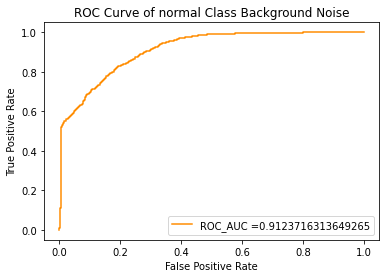

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy.special import softmax
import time
current_time = time.asctime( time.localtime(time.time()) )

fp_rate, tp_rate, _ = roc_curve(targets, anom_scores, pos_label=1)
roc_auc = roc_auc_score(targets, anom_scores)

plt.figure()
plt.plot(fp_rate, tp_rate, color='darkorange', label=f"ROC_AUC ={roc_auc}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of normal Class Background Noise')
plt.legend(loc="lower right")
plt.savefig('/content/drive/My Drive/models/baseline/roc_graph' + str(current_time) + "_" + str(roc_auc) + ".jpg")
plt.show()

In [26]:
print("Traininig finished! Saving Model...")
from google.colab import files
torch.save(autoencoder.state_dict(), '/content/drive/My Drive/models/baseline/' + str(current_time))

#save hyperparams and result:
with open('/content/drive/My Drive/models/baseline/hyper_params' + str(current_time) + '.txt', 'w') as f:
  f.write(f"Epochs: {EPOCHS}, LR: {LEARNING_RATE}, BatchSize: {BATCH_SIZE}, SAMPLE_RATE = {SAMPLE_RATE}, N_FFT/WINDOW_SIZE = {N_FFT}, HOP_LENGTH = {HOP_LENGTH}, N_MELS = {N_MELS}"
  + f"\nNormal Classes: {NORMAL_CLASSES}, Anomalous Classes: {ANOMALOUS_CLASSES}, ROC_AUC Score: {roc_auc}")

Traininig finished! Saving Model...


In [22]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
